In [1]:
# Load packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [ ]:
# Read datasets needed
from google.colab import files 
uploaded = files.upload()

In [3]:
import io
feature = pd.read_csv(io.BytesIO(uploaded['0817_X_imputed.csv'])) 
target = pd.read_csv(io.BytesIO(uploaded['0817_optimal_target.csv']))   #target means 'time to dietary consistency change'

In [4]:
feature_and_target = pd.merge(feature, target, on = 'SubjectID').drop(columns=['Unnamed: 0_x', 'Unnamed: 0_y'])
feature_and_target 

,SubjectID,Age,Gender,diag_delta,onset_delta,onset_site,diag_minus_onset,fvc_slope,fvc_mean,Creatinine_mean,Creatinine_slope,alsfrs_total_slope,mean_Q1_Speech,mean_Q2_Salivation,mean_Q3_Swallowing,mean_Q4_Handwriting,mean_Q5_Cutting,mean_Q6_Dressing_and_Hygiene,mean_Q7_Turning_in_Bed,mean_Q8_Walking,mean_Q9_Climbing_Stairs,mean_Q10_Respiratory,slope_Q1_Speech,slope_Q2_Salivation,slope_Q3_Swallowing,slope_Q4_Handwriting,slope_Q5_Cutting,slope_Q6_Dressing_and_Hygiene,slope_Q7_Turning_in_Bed,slope_Q8_Walking,slope_Q9_Climbing_Stairs,slope_Q10_Respiratory,weight_slope,time_opt,status_opt
0,329.0,4.0,0.0,-35.112329,-56.087671,0.0,20.975342,1.465187,101.250000,58.933333,-37.344907,1.739251,4.000000,3.000000,4.000000,3.000000,1.90,3.000000,2.600000,2.0,1.200000,3.200000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.844907,0.000000,0.422454,0.000000,-2.703704,274,0
1,708.0,6.0,1.0,-32.416438,-35.178082,1.0,2.761644,-1.883650,51.000000,88.400000,0.000000,-0.457380,3.000000,2.833333,2.666667,3.166667,3.75,3.166667,4.000000,4.0,2.833333,2.833333,0.000000,-0.334249,-0.334249,0.000000,0.000000,0.334249,0.000000,0.000000,0.000000,-0.334249,-3.309066,35,1
2,902.0,12.0,0.0,-1.610959,-16.898630,0.0,15.287671,-1.268576,89.600000,72.404103,8.317047,-1.194940,4.000000,3.750000,3.250000,4.000000,4.00,2.750000,4.000000,2.5,1.000000,3.000000,0.000000,0.000000,0.362103,0.000000,0.000000,-0.724206,0.000000,-0.362103,0.000000,-0.362103,-0.601648,154,0
3,1736.0,5.0,1.0,-16.800000,-18.739726,0.0,1.939726,0.000000,71.000000,58.400000,0.000000,-3.168403,2.500000,3.000000,3.000000,1.500000,1.00,1.000000,0.500000,0.5,0.000000,3.500000,-0.633681,-1.267361,0.000000,-0.633681,0.000000,0.000000,-0.633681,-0.633681,0.000000,0.633681,-1.933900,187,1
4,2492.0,9.0,1.0,-6.871233,-12.000000,0.0,5.128767,-7.156863,114.000000,66.300000,7.908333,0.000000,4.000000,4.000000,4.000000,3.000000,3.00,2.000000,3.000000,3.0,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,401,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2558,998756.0,9.0,1.0,-7.923288,-20.120548,1.0,12.197260,-7.759354,73.333333,103.961243,-16.540444,-0.530451,2.666667,2.666667,3.000000,3.000000,3.00,3.000000,4.000000,3.0,3.000000,2.000000,0.000000,-0.533626,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.310900,64,0
2559,999166.0,9.0,1.0,-1.610959,-32.843836,1.0,31.232877,-10.138889,75.000000,83.980000,5.845290,-1.697827,3.000000,3.000000,4.000000,4.000000,4.00,4.000000,3.000000,3.0,3.000000,4.000000,0.010513,-0.010934,0.164577,-0.166495,0.122598,-0.431570,-0.653074,-0.657898,-1.002338,0.421041,-3.206060,390,0
2560,999823.0,8.0,1.0,-2.761644,-16.175342,0.0,13.413699,-0.790247,100.800000,47.080505,6.328979,-0.773981,2.750000,3.000000,2.750000,4.000000,3.75,3.000000,4.000000,4.0,4.000000,4.000000,-0.370935,0.000000,-0.370935,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.534799,91,1
2561,999880.0,7.0,1.0,-69.205479,-94.191781,0.0,24.986301,-2.406327,50.250000,88.400000,0.000000,0.352317,4.000000,4.000000,4.000000,2.000000,1.00,0.400000,2.800000,2.0,0.000000,4.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.434524,0.000000,0.000000,0.000000,0.000000,-0.217262,266,0


In [5]:
# Check the proportion of censored data
event_distribution = pd.DataFrame(feature_and_target[['status_opt']].value_counts()).reset_index()
event_distribution.columns = ['status', 'count']
event_distribution['status'] = event_distribution['status'].astype('bool')
event_distribution = event_distribution.replace({'status': {False:'0 (censored)', True:'1 (occured)'}})
print(event_distribution)

         status  count
0  0 (censored)   1717
1   1 (occured)    846


In [7]:
# Separate 5 subjects for demonstration purpose
df_demonstration = feature_and_target.sample(n=5, random_state = 12)
demonstrationID_list = list(df_demonstration['SubjectID'])

# The other 2558 subjects are used for feature selection & fitting
data_for_fitting = feature_and_target[~(feature_and_target['SubjectID'].isin(demonstrationID_list))].drop(columns = 'SubjectID')
y = data_for_fitting[['status_opt']]

from sklearn.model_selection import train_test_split
df_train, df_test, y_train, y_test = train_test_split(data_for_fitting, y, train_size=0.8, test_size=0.2, random_state=11)

In [9]:
print(df_demonstration)
print(df_train)
print(df_test)

      SubjectID   Age  Gender  ...  weight_slope  time_opt  status_opt
1464   585126.0   7.0     1.0  ...      2.129167      1653           1
247    101480.0   6.0     0.0  ...      0.434524       259           1
2075   827801.0   3.0     1.0  ...     -1.100758       406           0
2440   959075.0  11.0     1.0  ...     -0.707364       370           0
1606   632540.0   9.0     0.0  ...      0.375514       399           0

[5 rows x 35 columns]
       Age  Gender  diag_delta  ...  weight_slope  time_opt  status_opt
157    8.0     1.0   -8.975342  ...     -1.647569       353           1
2312   4.0     1.0  -10.224658  ...      0.760417       389           0
1143   7.0     0.0   -2.038356  ...     -0.214577       420           0
2031   7.0     1.0   -5.621918  ...      0.442424       202           1
1340  10.0     1.0  -22.915068  ...     -0.422454       268           0
...    ...     ...         ...  ...           ...       ...         ...
1700   9.0     1.0   -0.197260  ...      1.9278

# 1. Stepwise Selection

In [ ]:
pip install lifelines

In [11]:
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index

In [13]:
initial_train = df_train.copy()
initial_feature = ['Age', 'Gender', 'diag_delta', 'onset_delta', 'onset_site', 'diag_minus_onset', 'fvc_slope', 'fvc_mean', 'Creatinine_mean',
       'Creatinine_slope', 'alsfrs_total_slope', 'mean_Q1_Speech', 'mean_Q2_Salivation', 'mean_Q3_Swallowing', 'mean_Q4_Handwriting',
       'mean_Q5_Cutting', 'mean_Q6_Dressing_and_Hygiene', 'mean_Q7_Turning_in_Bed', 'mean_Q8_Walking', 'mean_Q9_Climbing_Stairs',
       'mean_Q10_Respiratory', 'slope_Q1_Speech', 'slope_Q2_Salivation', 'slope_Q3_Swallowing', 'slope_Q4_Handwriting', 'slope_Q5_Cutting',
       'slope_Q6_Dressing_and_Hygiene', 'slope_Q7_Turning_in_Bed', 'slope_Q8_Walking', 'slope_Q9_Climbing_Stairs', 'slope_Q10_Respiratory',
       'weight_slope']
SL = 0.05

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Speci

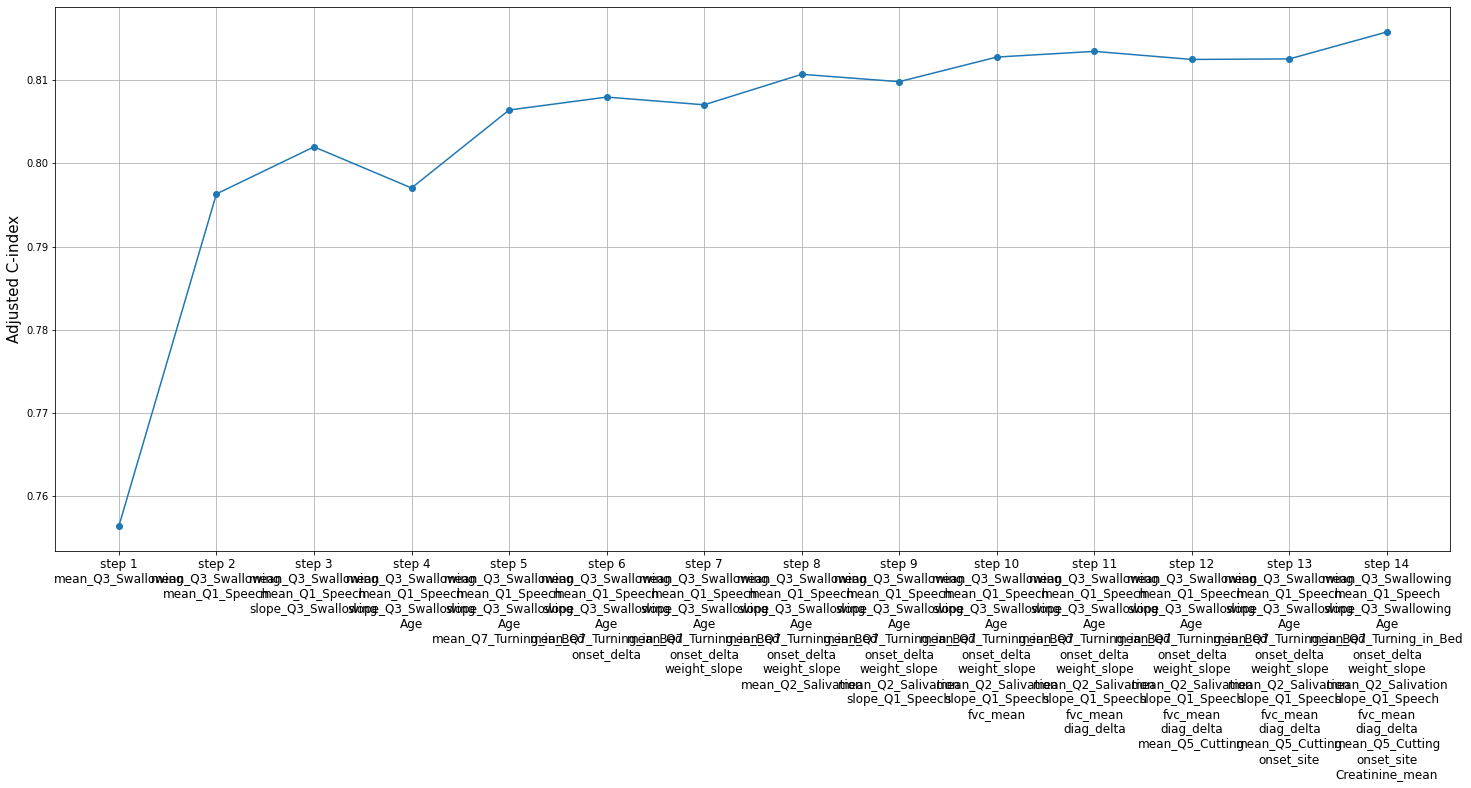

In [14]:
def cph_forward_stepwise_elimination(initial_train, initial_test, initial_feature, SL_enter, SL_remove):
    
    train = initial_train.copy()
    test = initial_test.copy()
    feature_list = initial_feature.copy()
    selected_feature_list = []

    sv_per_step = []
    adjusted_c_index = []
    steps = []
    step = 0

    while len(feature_list) > 0:
        remainder = list(set(feature_list) - set(selected_feature_list))
        pval = pd.Series(index=remainder)

        for col in remainder:
          X = train[selected_feature_list + [col] + ['time_opt', 'status_opt']]
          cph = CoxPHFitter(penalizer = 0.01)
          cph.fit(X, duration_col='time_opt', event_col='status_opt')
          pval[col] = cph.summary['p'][col]

        min_pval = pval.min()
        if min_pval < SL_enter:
          selected_feature_list.append(pval.idxmin())

          while len(selected_feature_list) > 0:
            selected_X = train[selected_feature_list + ['time_opt', 'status_opt']]
            cph = CoxPHFitter(penalizer = 0.01)
            cph.fit(selected_X, duration_col='time_opt', event_col='status_opt')
            selected_pval = cph.summary['p']
            max_pval = selected_pval.max()
            if max_pval >= SL_remove:
              remove_feature = selected_pval.idxmax()
              selected_feature_list.remove(remove_feature)
            else:
              break

          step += 1
          steps.append(step)
          selected_train = train[selected_feature_list + ['time_opt', 'status_opt']]
          selected_test = test[selected_feature_list + ['time_opt', 'status_opt']]
          cph = CoxPHFitter(penalizer = 0.01)
          cph.fit(selected_train, 'time_opt', event_col='status_opt')
          adj_c_index = concordance_index(selected_test['time_opt'], -cph.predict_partial_hazard(selected_test), selected_test['status_opt'])   
          adjusted_c_index.append(adj_c_index) 
          sv_per_step.append(selected_feature_list.copy())

        else: 
          break

    fig = plt.figure(figsize=(25,10))
    fig.set_facecolor('white')
 
    font_size = 15
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)], fontsize=12)
    plt.plot(steps,adjusted_c_index, marker='o')
    
    plt.ylabel('Adjusted C-index',fontsize=font_size)
    plt.grid(True)
    plt.show()

    return selected_feature_list

cph_stepwise_selected_feature = cph_forward_stepwise_elimination(initial_train, df_test,initial_feature, 0.05, 0.05)

In [17]:
# Selection results
cph_stepwise_selected_feature

['mean_Q3_Swallowing',
 'mean_Q1_Speech',
 'slope_Q3_Swallowing',
 'Age',
 'mean_Q7_Turning_in_Bed',
 'onset_delta',
 'weight_slope',
 'mean_Q2_Salivation',
 'slope_Q1_Speech',
 'fvc_mean',
 'diag_delta',
 'mean_Q5_Cutting',
 'onset_site',
 'Creatinine_mean']

# 2. Check multicollinearity

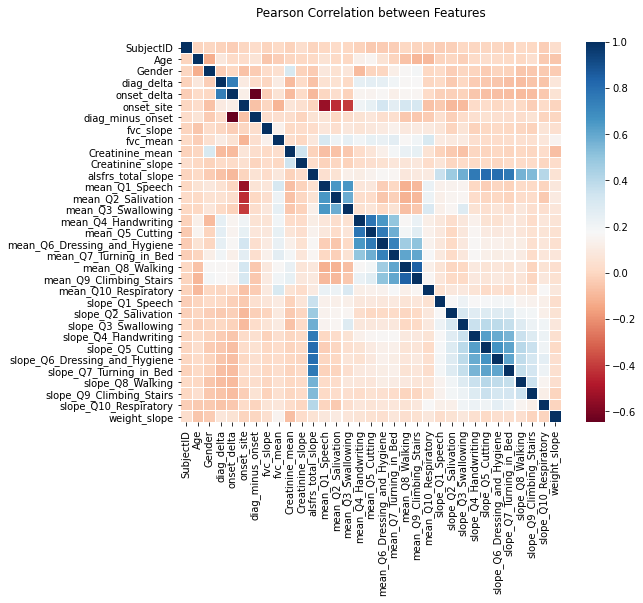

In [20]:
colormap = plt.cm.RdBu
plt.figure(figsize=(9, 7))
plt.title('Pearson Correlation between Features', y=1.05, size=12)
sns.heatmap(feature_and_target.drop(columns = ['time_opt', 'status_opt']).astype(float).corr(), linewidths=0.1, vmax=1.0,
   square=True, cmap=colormap, linecolor='white', annot=False)
# 'onset_site' highly related to 'mean_Q1~Q3'
# 'diag_delta' highly related to 'onset_delta'

# 3. Finalize feature selection

### Add or remove some features, based in features chosen by stepwise selection

In [21]:
# Remove 'diag delta'
# Add a meta feature 'mean_Q1_2_3_mouth'
feature['mean_Q1_2_3_mouth'] = feature['mean_Q1_Speech'] + feature['mean_Q2_Salivation'] + feature['mean_Q3_Swallowing']
# Remove 'onset site', 'mean_Q1_Speech','mean_Q2_Salivation', 'mean_Q3_Swallowing'

In [24]:
# Final list
feature_list = ['Age', 'onset_delta', 'fvc_mean', 'Creatinine_mean', 'mean_Q1_2_3_mouth', 'mean_Q5_Cutting', 
                'mean_Q7_Turning_in_Bed', 'slope_Q1_Speech', 'slope_Q3_Swallowing', 'weight_slope']
feature_list

['Age',
 'onset_delta',
 'fvc_mean',
 'Creatinine_mean',
 'mean_Q1_2_3_mouth',
 'mean_Q5_Cutting',
 'mean_Q7_Turning_in_Bed',
 'slope_Q1_Speech',
 'slope_Q3_Swallowing',
 'weight_slope']